In [1]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Lambda, Flatten, Reshape, MaxPooling2D
from keras.models import Model
from keras.losses import mean_squared_error, binary_crossentropy, kullback_leibler_divergence
from keras.callbacks import EarlyStopping, TerminateOnNaN, ReduceLROnPlateau
from keras import backend as K
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, scipy
from sklearn.model_selection import train_test_split

from phenom_read_in_data import *

Using TensorFlow backend.


In [2]:
#Getthe data
df = csv_to_df('ttbarZ/')

In [3]:
df

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,...,obj12,E12,pt12,eta12,phi12,obj13,E13,pt13,eta13,phi13
0,21,ttbarZ,1,43924.6,-0.38825,j,165476,165097,-0.0171131,-1.54448,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21,ttbarZ,1,45289,-3.09984,j,105746,95333.9,0.449145,1.79273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,ttbarZ,1,16530.4,-3.09183,b,144211,137971,0.100321,-0.0772316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21,ttbarZ,1,18362.9,1.14058,b,370358,120835,1.78374,-0.757091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21,ttbarZ,1,232797,-2.74669,j,436613,432317,-0.110325,0.656242,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5869,21,ttbarZ,1,17569.3,3.08905,j,223425,161759,-0.840404,2.52008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5870,21,ttbarZ,1,70402.4,-1.12592,b,340938,86263.4,-2.05015,-0.018614,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5871,21,ttbarZ,1,28553.9,0.862966,j,116154,114311,0.0884322,-2.74727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5872,21,ttbarZ,1,183633,1.98713,j,350312,178245,1.29249,0.477881,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
#If the number of max objects is prime, another column needs to be added to mitigate 

In [38]:
df['obj14']= -999
df['E14'] = -999
df['pt14'] = -999
df['eta14'] = -999
df['phi14'] = -999

In [39]:
df = df.fillna(-999)
variables = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']

In [17]:
objects = []
for i in df.columns:
    if i[:3] == 'obj':
        objects.append(i)

In [41]:
j_objects = df.loc[df['obj1'] == 'j', df.columns[:10]]

In [42]:
j_objects

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1
0,21,ttbarZ,1,43924.6,-0.38825,j,165476,165097,-0.0171131,-1.54448
1,21,ttbarZ,1,45289,-3.09984,j,105746,95333.9,0.449145,1.79273
4,21,ttbarZ,1,232797,-2.74669,j,436613,432317,-0.110325,0.656242
5,21,ttbarZ,1,158251,-2.69637,j,265871,210909,-0.671705,-2.92575
6,21,ttbarZ,1,40816.3,2.88688,j,296867,102488,-1.72479,1.81765
...,...,...,...,...,...,...,...,...,...,...
5868,21,ttbarZ,1,58836.3,-0.379895,j,227671,149490,-0.959438,-2.704
5869,21,ttbarZ,1,17569.3,3.08905,j,223425,161759,-0.840404,2.52008
5871,21,ttbarZ,1,28553.9,0.862966,j,116154,114311,0.0884322,-2.74727
5872,21,ttbarZ,1,183633,1.98713,j,350312,178245,1.29249,0.477881


In [58]:
j_objects = j_objects[['process_ID']+['E1', 'pt1', 'eta1', 'phi1']]
one_hot = pd.get_dummies(j_objects['process_ID'])
processes = one_hot.columns
j_objects.drop('process_ID', axis = 'columns', inplace = True)
j_objects = pd.concat([j_objects, one_hot], sort = False, axis = 1)

/home/joe/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#Now we one_hot encode the data to make sure we have a class definition
df = df[['process_ID']+variables]
one_hot = pd.get_dummies(df['process_ID'])
processes = one_hot.columns
df.drop('process_ID', axis = 'columns', inplace = True)
df = pd.concat([df, one_hot], sort = False, axis = 1)

df

In [59]:
j_objects

,E1,pt1,eta1,phi1,ttbarZ
0,165476,165097,-0.0171131,-1.54448,1
1,105746,95333.9,0.449145,1.79273,1
4,436613,432317,-0.110325,0.656242,1
5,265871,210909,-0.671705,-2.92575,1
6,296867,102488,-1.72479,1.81765,1
...,...,...,...,...,...
5868,227671,149490,-0.959438,-2.704,1
5869,223425,161759,-0.840404,2.52008,1
5871,116154,114311,0.0884322,-2.74727,1
5872,350312,178245,1.29249,0.477881,1


In [60]:
#We have created a df of our values and some kind of class label
#We should normalize
x = j_objects[['E1', 'pt1', 'eta1', 'phi1']].values
x_scaled = StandardScaler().fit_transform(x)
j_objects[['E1', 'pt1', 'eta1', 'phi1']] = x_scaled

x_train, x_test, y_train, y_test = train_test_split(j_objects[['E1', 'pt1', 'eta1', 'phi1']].values,
						    j_objects[processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

In [62]:
x_train.shape

(3570, 4)

In [63]:
#Reshape the data. This will have to be done explicitly until you think of a clever way of doing it
x_train = x_train.reshape((x_train.shape[0], 4, 1, 1))
x_test = x_test.reshape((x_test.shape[0], 4, 1, 1))

In [64]:
def sampling(args):
    z_mean, z_log_var=args
    epsilon=tf.random.uniform(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean+K.exp(z_log_var/2)*epsilon

In [65]:
#VAE Model
original_dim = x_train.shape[0]
input_shape = x_train.shape[1:]
latent_dim = 4
intermediate_dim = 50
kernel_max_norm = 1000.
act_fun = 'relu'
epsilon_std = 1.
filters = 32
kernel_size = (3, 3)
strides = (1, 1)


In [66]:
#Layers
x_input = Input(shape = input_shape, name = 'Input')
conv_1 = Conv2D(filters = filters, 
                activation = act_fun,
                kernel_size = kernel_size,
                strides = strides, 
                padding = 'same')(x_input)
pool_1 = MaxPooling2D(pool_size = (1, 1),
                      strides = 2,
                      #data_format = 'channels_first'
                     )(conv_1)
conv_2 = Conv2D(filters = filters, 
                activation = act_fun, 
                kernel_size = kernel_size, 
                strides = strides, 
                padding = 'same')(pool_1)

#Shape info needed to inform the dense layer in the decoder
flatten = Flatten()(conv_2)
#cnn = Model(x_input, flatten, name = 'cnn')
#cnn.summary()

shape = input_shape

In [67]:
#Encoding
dense_encoder_1 = Dense(intermediate_dim,
                        activation = act_fun,
                        name = 'dense_encoder_1')(flatten)
dense_encoder_2 = Dense(16,
                        activation = act_fun,
                        name = 'dense_encoder_2')(dense_encoder_1)
z_mean = Dense(latent_dim, name = 'z_mean')(dense_encoder_2)
z_var = Dense(latent_dim, name = 'z_var')(dense_encoder_2)

z = Lambda(sampling, output_shape = (latent_dim, ), name = 'sampling')([z_mean, z_var])

encoder = Model(x_input, [z_mean, z_var, z], name = 'encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 4, 1, 1)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 1, 32)     320         Input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 2, 1, 32)     0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 2, 1, 32)     9248        max_pooling2d_1[0][0]            
____________________________________________________________________________________________

In [68]:
#Decoding
decoder_input = Input(shape = (latent_dim, ), name = 'decoder_input')
dense_decoder_1 = Dense(shape[0]*shape[1]*shape[2], 
                        activation = act_fun, name = 'dense_decoder_1')(decoder_input)
reshape = Reshape((shape[0], shape[1], shape[2]))(dense_decoder_1)

deconv_1 = Conv2DTranspose(filters = filters,
                           kernel_size = kernel_size, 
                           activation = act_fun, 
                           strides = strides, 
                           padding = 'same', 
                           name = 'deconv_1')(reshape)
deconv_2 = Conv2DTranspose(filters = 16,
                           kernel_size = kernel_size, 
                           activation = act_fun, 
                           strides = strides, 
                           padding = 'same', 
                           name = 'deconv_2')(deconv_1)

output = Conv2DTranspose(filters = 1, 
                         kernel_size = kernel_size, 
                         activation = 'sigmoid', 
                         padding = 'same', 
                         strides = strides, 
                         name = 'decoder_output')(deconv_2)

decoder = Model(decoder_input, output, name = 'decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 4)                 0         
_________________________________________________________________
dense_decoder_1 (Dense)      (None, 4)                 20        
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 1, 1)           0         
_________________________________________________________________
deconv_1 (Conv2DTranspose)   (None, 4, 1, 32)          320       
_________________________________________________________________
deconv_2 (Conv2DTranspose)   (None, 4, 1, 16)          4624      
_________________________________________________________________
decoder_output (Conv2DTransp (None, 4, 1, 1)           145       
Total params: 5,109
Trainable params: 5,109
Non-trainable params: 0
_________________________________________________________

In [69]:
#Build the VAE model
outputs = decoder(encoder(x_input)[2])
vae = Model(x_input, outputs, name = 'vae')

In [70]:
#Define some losses
def kl_loss(y_true, y_pred):
    kl_loss = 1 + z_var - K.square(z_mean) - K.exp(z_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    #kl_loss = K.mean(kl_loss)
    return kl_loss

def recon_loss(y_true, y_pred):
    recon_loss = mean_squared_error(K.flatten(y_true), K.flatten(y_pred))
    recon_loss *= shape[0]*shape[1]*shape[2]
    #recon_loss = K.mean(recon_loss)
    return recon_loss

def my_vae_loss(y_true, y_pred):
    recon = recon_loss(y_true, y_pred) 
    kl = kl_loss(y_true, y_pred)
    vae_loss = recon + kl
    return vae_loss


In [71]:
vae.compile(optimizer = 'rmsprop', loss = my_vae_loss, metrics = [kl_loss, recon_loss])
vae.summary()


Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 4, 1, 1)           0         
_________________________________________________________________
encoder (Model)              [(None, 4), (None, 4), (N 13770     
_________________________________________________________________
decoder (Model)              (None, 4, 1, 1)           5109      
Total params: 18,879
Trainable params: 18,879
Non-trainable params: 0
_________________________________________________________________


In [72]:
#Fit the model
epochs = 100
batch_size = 100

history = vae.fit(x = x_train,
                  y = x_train,
                  validation_data = (x_train, x_train),
                  epochs = epochs,
                  batch_size = batch_size,
                  verbose = 2)

vae.save('cnn-vae_model.h5')

Train on 3570 samples, validate on 3570 samples
Epoch 1/100
 - 1s - loss: 4.5688 - kl_loss: 0.0415 - recon_loss: 4.5220 - val_loss: 4.0881 - val_kl_loss: 0.0783 - val_recon_loss: 4.0096
Epoch 2/100
 - 0s - loss: 3.9736 - kl_loss: 0.0824 - recon_loss: 3.8882 - val_loss: 3.8849 - val_kl_loss: 0.0954 - val_recon_loss: 3.7893
Epoch 3/100
 - 0s - loss: 3.7921 - kl_loss: 0.1094 - recon_loss: 3.6901 - val_loss: 3.6988 - val_kl_loss: 0.1188 - val_recon_loss: 3.5793
Epoch 4/100
 - 0s - loss: 3.6577 - kl_loss: 0.1306 - recon_loss: 3.5214 - val_loss: 3.6235 - val_kl_loss: 0.1208 - val_recon_loss: 3.5024
Epoch 5/100
 - 0s - loss: 3.5758 - kl_loss: 0.1344 - recon_loss: 3.4372 - val_loss: 3.5326 - val_kl_loss: 0.1300 - val_recon_loss: 3.4016
Epoch 6/100
 - 0s - loss: 3.4818 - kl_loss: 0.1544 - recon_loss: 3.3255 - val_loss: 3.4212 - val_kl_loss: 0.1826 - val_recon_loss: 3.2380
Epoch 7/100
 - 0s - loss: 3.3590 - kl_loss: 0.1785 - recon_loss: 3.1741 - val_loss: 3.3050 - val_kl_loss: 0.1796 - val_recon

Epoch 60/100
 - 0s - loss: 2.7617 - kl_loss: 0.2480 - recon_loss: 2.5070 - val_loss: 2.7741 - val_kl_loss: 0.2457 - val_recon_loss: 2.5275
Epoch 61/100
 - 0s - loss: 2.7820 - kl_loss: 0.2528 - recon_loss: 2.5306 - val_loss: 2.7627 - val_kl_loss: 0.2445 - val_recon_loss: 2.5176
Epoch 62/100
 - 0s - loss: 2.7774 - kl_loss: 0.2465 - recon_loss: 2.5317 - val_loss: 2.7776 - val_kl_loss: 0.2657 - val_recon_loss: 2.5109
Epoch 63/100
 - 0s - loss: 2.7713 - kl_loss: 0.2561 - recon_loss: 2.5123 - val_loss: 2.7556 - val_kl_loss: 0.2539 - val_recon_loss: 2.5005
Epoch 64/100
 - 0s - loss: 2.7684 - kl_loss: 0.2537 - recon_loss: 2.5254 - val_loss: 2.7724 - val_kl_loss: 0.2704 - val_recon_loss: 2.5011
Epoch 65/100
 - 0s - loss: 2.7691 - kl_loss: 0.2561 - recon_loss: 2.5110 - val_loss: 2.7571 - val_kl_loss: 0.2459 - val_recon_loss: 2.5104
Epoch 66/100
 - 0s - loss: 2.7654 - kl_loss: 0.2534 - recon_loss: 2.5206 - val_loss: 2.7873 - val_kl_loss: 0.2582 - val_recon_loss: 2.5281
Epoch 67/100
 - 0s - loss: 

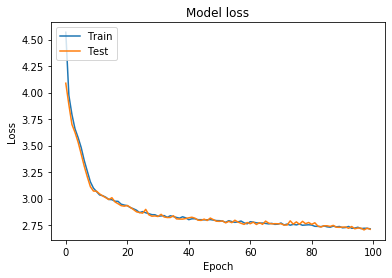

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [74]:
vae.metrics_names

['loss', 'kl_loss', 'recon_loss']

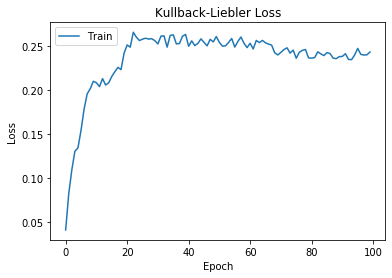

In [75]:
plt.plot(history.history['kl_loss'])
plt.title('Kullback-Liebler Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

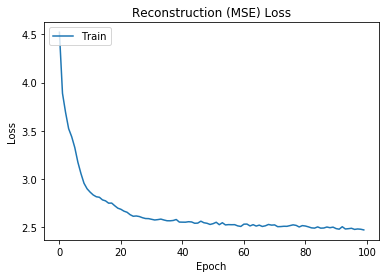

In [76]:
plt.plot(history.history['recon_loss'])
plt.title('Reconstruction (MSE) Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [77]:
recon_num = len(history.history['recon_loss'])
loss_num = len(history.history['loss'])

In [78]:
print(recon_num, loss_num)

100 100


In [79]:
loss_diffs = [history.history['loss'][i]-history.history['recon_loss'][i] for i in range(loss_num)]

In [86]:
len(loss_diffs)

100

In [80]:
epochs = [i+1 for i in range(100)]

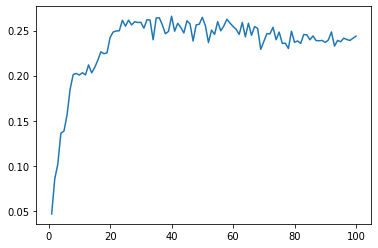

In [81]:
plt.plot(epochs,loss_diffs)

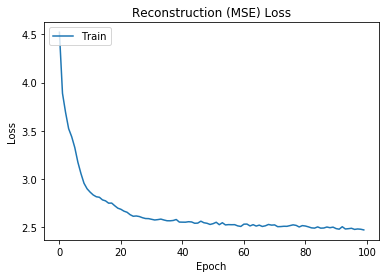

In [82]:
plt.plot(history.history['recon_loss'])
plt.title('Reconstruction (MSE) Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [83]:
anom_df = csv_to_df('gluino/')

In [84]:
anom_df

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,...,obj18,E18,pt18,eta18,phi18,obj19,E19,pt19,eta19,phi19
0,21,gluino_01,1,332161,2.26593,j,760637,734103,0.126973,-0.501123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21,gluino_01,1,341970,-1.54051,j,268137,239144,0.484389,0.80585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,gluino_01,1,127593,-0.838665,j,282508,169404,-1.08989,3.13979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21,gluino_01,1,254820,-1.21007,j,492500,202743,-1.53279,-1.11323,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21,gluino_01,1,88214.6,0.365631,j,546629,482738,0.49185,3.0645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2723,30,gluino_02,1,566719,2.51652,j,725980,610037,-0.560869,-0.689265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2724,30,gluino_02,1,295629,1.0568,j,798406,485601,1.07319,-1.12604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2725,30,gluino_02,1,530588,-0.2132,j,558691,473738,-0.502534,3.06139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2726,30,gluino_02,1,128680,0.759799,j,280771,271452,0.0784046,-1.42927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
anom_df.columns

Index(['event_ID', 'process_ID', 'event_weight', 'MET', 'MET_Phi', 'obj1',
       'E1', 'pt1', 'eta1', 'phi1', 'obj2', 'E2', 'pt2', 'eta2', 'phi2',
       'obj3', 'E3', 'pt3', 'eta3', 'phi3', 'obj4', 'E4', 'pt4', 'eta4',
       'phi4', 'obj5', 'E5', 'pt5', 'eta5', 'phi5', 'obj6', 'E6', 'pt6',
       'eta6', 'phi6', 'obj7', 'E7', 'pt7', 'eta7', 'phi7', 'obj8', 'E8',
       'pt8', 'eta8', 'phi8', 'obj9', 'E9', 'pt9', 'eta9', 'phi9', 'obj10',
       'E10', 'pt10', 'eta10', 'phi10', 'obj11', 'E11', 'pt11', 'eta11',
       'phi11', 'obj12', 'E12', 'pt12', 'eta12', 'phi12', 'obj13', 'E13',
       'pt13', 'eta13', 'phi13', 'obj14', 'E14', 'pt14', 'eta14', 'phi14',
       'obj15', 'E15', 'pt15', 'eta15', 'phi15', 'obj16', 'E16', 'pt16',
       'eta16', 'phi16', 'obj17', 'E17', 'pt17', 'eta17', 'phi17', 'obj18',
       'E18', 'pt18', 'eta18', 'phi18', 'obj19', 'E19', 'pt19', 'eta19',
       'phi19'],
      dtype='object')

In [86]:
anom_df = anom_df[anom_df.columns[:75]]

In [87]:
anom_df

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,...,obj13,E13,pt13,eta13,phi13,obj14,E14,pt14,eta14,phi14
0,21,gluino_01,1,332161,2.26593,j,760637,734103,0.126973,-0.501123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21,gluino_01,1,341970,-1.54051,j,268137,239144,0.484389,0.80585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,gluino_01,1,127593,-0.838665,j,282508,169404,-1.08989,3.13979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21,gluino_01,1,254820,-1.21007,j,492500,202743,-1.53279,-1.11323,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21,gluino_01,1,88214.6,0.365631,j,546629,482738,0.49185,3.0645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2723,30,gluino_02,1,566719,2.51652,j,725980,610037,-0.560869,-0.689265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2724,30,gluino_02,1,295629,1.0568,j,798406,485601,1.07319,-1.12604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2725,30,gluino_02,1,530588,-0.2132,j,558691,473738,-0.502534,3.06139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2726,30,gluino_02,1,128680,0.759799,j,280771,271452,0.0784046,-1.42927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


anom_df = anom_df.fillna(0)
anom_vars = [entry for entry in anom_df.columns if entry[0] == 'E'] + [entry for entry in anom_df.columns if entry[0:2] == 'pt'] + [entry for entry in anom_df.columns if entry[0:2] == 'et'] + [entry for entry in anom_df.columns if entry[0:2] == 'ph']
#Now we one_hot encode the data to make sure we have a class definition
anom_df = anom_df[['process_ID']+anom_vars]
anom_one_hot = pd.get_dummies(anom_df['process_ID'])
anom_processes = anom_one_hot.columns
anom_df.drop('process_ID', axis = 'columns', inplace = True)
anom_df = pd.concat([anom_df, anom_one_hot], sort = False, axis = 1)

#We have created a df of our values and some kind of class label
#We should normalize
anom_x = anom_df[anom_vars].values
anom_scaled = StandardScaler().fit_transform(anom_x)
anom_df[anom_vars] = anom_scaled

anom_x_train, anom_x_test, anom_y_train, anom_y_test = train_test_split(anom_df[anom_vars].values,
						    anom_df[anom_processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

In [88]:
anom_df = anom_df.fillna(-999)
anom_vars = ['E1', 'pt1', 'eta1', 'phi1']

In [91]:
anom_objects = []
for i in anom_df.columns:
    if i[:3] == 'obj':
        anom_objects.append(i)

In [95]:
anom_jobjects = anom_df.loc[anom_df['obj1'] == 'j', anom_df.columns[:10]]

In [96]:
#Now we one_hot encode the data to make sure we have a class definition
anom_jobjects = anom_jobjects[['process_ID']+anom_vars]
anom_j_one_hot = pd.get_dummies(anom_jobjects['process_ID'])
anom_j_processes = anom_j_one_hot.columns
anom_jobjects.drop('process_ID', axis = 'columns', inplace = True)
anom_jobjects = pd.concat([anom_jobjects, anom_j_one_hot], sort = False, axis = 1)

/home/joe/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [98]:
#We have created a df of our values and some kind of class label
#We should normalize
anom_j_x = anom_jobjects[anom_vars].values
anom_j_scaled = StandardScaler().fit_transform(anom_j_x)
anom_jobjects[anom_vars] = anom_j_scaled

anom_x_train, anom_x_test, anom_y_train, anom_y_test = train_test_split(anom_jobjects[anom_vars].values,
						    anom_jobjects[anom_j_processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

In [100]:
#Reshape the data. This will have to be done explicitly until you think of a clever way of doing it
anom_x_train = anom_x_train.reshape((anom_x_train.shape[0], 4, 1, 1))
anom_x_test = anom_x_test.reshape((anom_x_test.shape[0], 4, 1, 1))

In [103]:
vae.evaluate(x_train[:1000], anom_x_train[:1000])

1000/1000 [==============================] - 0s 33us/step


[5.232097862243652, 0.24927838146686554, 4.975127696990967]

In [102]:
#Original model results:   loss: 2.7147 - kl_loss: 0.2429 - recon_loss: 2.4710 

In [6]:
pd.set_option('display.max_columns', 75)

In [7]:
df

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,obj2,E2,pt2,eta2,phi2,obj3,E3,pt3,eta3,phi3,obj4,E4,pt4,eta4,phi4,obj5,E5,pt5,eta5,phi5,obj6,E6,pt6,eta6,phi6,obj7,E7,pt7,eta7,phi7,obj8,E8,pt8,eta8,phi8,obj9,E9,pt9,eta9,phi9,obj10,E10,pt10,eta10,phi10,obj11,E11,pt11,eta11,phi11,obj12,E12,pt12,eta12,phi12,obj13,E13,pt13,eta13,phi13
0,21,ttbarZ,1,43924.6,-0.38825,j,165476,165097,-0.0171131,-1.54448,j,163744,161051,-0.127864,1.89464,b,86228.2,78559.5,-0.393297,3.05707,j,68231.7,67934.1,-0.0262432,1.12407,j,40452,36900.9,-0.419573,-2.32306,j,36919.8,34203.1,0.303205,-0.614197,j,31126.3,24639.1,0.678827,0.396069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21,ttbarZ,1,45289,-3.09984,j,105746,95333.9,0.449145,1.79273,j,106214,92717.5,-0.52132,-0.624799,j,273538,63046.7,2.14564,0.166455,b,74094.3,53404,0.848482,-1.91912,j,37460.9,36739.6,0.183794,3.06706,b,45106.4,36630.5,-0.642508,-2.75669,j,72748.1,34023.2,-1.38809,0.632568,j,135412,29152.7,2.21505,2.39706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,ttbarZ,1,16530.4,-3.09183,b,144211,137971,0.100321,-0.0772316,j,195882,87466,1.44049,2.31974,j,152950,65054.9,1.49544,-3.03641,b,89301.6,61292.3,0.915048,-1.8527,j,332144,44061.6,2.70825,0.615086,j,56815.5,35907.4,-1.03082,-1.96102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21,ttbarZ,1,18362.9,1.14058,b,370358,120835,1.78374,-0.757091,j,156700,107113,0.912321,2.38575,j,90473.5,79780.5,-0.504302,-2.71376,j,116668,72019.3,1.04829,-0.322966,b,277522,70059.8,2.05196,0.062623,j,487093,68214.4,2.65376,2.27298,j,148612,45663.6,1.84695,-2.93225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21,ttbarZ,1,232797,-2.74669,j,436613,432317,-0.110325,0.656242,b,185625,182595,-0.0154071,-2.69834,j,202016,134513,-0.949922,-0.73823,j,153539,71250.1,-1.40028,2.0433,j,80299.9,52919.8,0.974133,-2.44932,j,162664,46091.9,-1.93104,-2.30425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5869,21,ttbarZ,1,17569.3,3.08905,j,223425,161759,-0.840404,2.52008,b,212922,150108,0.871115,-1.46624,j,107559,104874,-0.09206,1.86163,j,521781,87172.3,2.47494,-0.528776,j,110667,84358.7,0.754226,0.234181,j,319253,52431.5,-2.49247,2.77751,j,43875.6,39472.2,-0.46807,-1.35213,j,159489,35116,2.19302,1.42717,j,76563.8,26379.1,1.72649,-0.62969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5870,21,ttbarZ,1,70402.4,-1.12592,b,340938,86263.4,-2.05015,-0.018614,b,80266,79630.8,0.0892557,1.44809,j,98983.4,56366.9,-1.1629,2.92059,j,44193.9,44005.6,-0.0908837,-2.35942,j,46323.3,42138.8,0.404271,2.09979,j,149315,27061.5,-2.39208,-1.38726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5871,21,ttbarZ,1,28553.9,0.862966,j,116154,114311,0.0884322,-2.74727,j,193623,94304.2,1.3457,1.29583,b,164252,66516.6,1.54902,0.167349,j,332013,40321.4,-2.79728,0.600107,j,37773.4,29133.9,0.709713,-1.52097,j,73094.2,27742.1,-1.62051,-1.09525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5872,21,ttbarZ,1,183633,1.98713,j,350312,178245,1.29249,0.477881,j,112870,109878,0.218633,-2.54255,j,81252,74631.8,-0.354966,-1.88837,j,167830,71985.2,-1.48892,-1.91709,j,325596,53747.1,-2.48624,-0.555373,b,42017.8,3696

In [8]:
df.describe()

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,obj2,E2,pt2,eta2,phi2,obj3,E3,pt3,eta3,phi3,obj4,E4,pt4,eta4,phi4,obj5,E5,pt5,eta5,phi5,obj6,E6,pt6,eta6,phi6,obj7,E7,pt7,eta7,phi7,obj8,E8,pt8,eta8,phi8,obj9,E9,pt9,eta9,phi9,obj10,E10,pt10,eta10,phi10,obj11,E11,pt11,eta11,phi11,obj12,E12,pt12,eta12,phi12,obj13,E13,pt13,eta13,phi13
count,5874,5874,5874,5874,5874,5874,5874,5874,5874,5874,5871,5871,5871,5871,5871,5825,5825,5825,5825,5825,5583,5583,5583,5583,5583,4970,4970,4970,4970,4970,3792,3792,3792,3792,3792,2339,2339,2339,2339,2339,1158,1158,1158,1158,1158,434,434,434,434,434,139,139,139,139,139,35,35,35,35,35,10,10,10,10,10,2,2,2,2,2
unique,1,1,1,5859,5847,2,5843,5818,5859,5856,6,5831,5826,5859,5839,7,5799,5805,5804,5805,7,5561,5562,5564,5570,7,4950,4953,4955,4948,7,3788,3781,3784,3788,7,2331,2322,2335,2336,7,1155,1156,1157,1157,7,434,434,434,434,7,139,139,139,139,6,35,35,35,35,3,10,10,10,10,1,2,2,2,2
top,21,ttbarZ,1,143597,-1.0208,j,121668,137959,-1.16287,2.91497,j,116980,107334,0.457036,-2.53942,j,169380,113515,2.18699,2.80313,j,27444,29510.3,-1.0267,2.64801,j,85074.9,41799.2,-1.23156,2.04085,j,107118,31956.4,1.69999,3.05506,j,127890,25439.6,-1.35031,-1.5078,j,185419,23922.7,-1.59418,-2.30007,j,147454,23487.9,-0.904217,1.8527,j,214785,26832.9,2.03731,-2.22889,j,789173,37972.8,-0.0590214,0.853857,j,76906.5,27271.7,-0.0629869,-1.9746,j,42197.8,35040.1,-1.10318,1.77787
freq,5874,5874,5874,2,2,3967,2,3,2,2,3986,2,2,2,2,4220,2,2,2,2,4129,2,2,2,2,3644,2,2,2,2,2726,2,2,2,2,1678,2,2,2,2,770,2,2,2,2,300,1,1,1,1,98,1,1,1,1,27,1,1,1,1,8,1,1,1,1,2,1,1,1,1


In [28]:
df.describe('obj12')

TypeError: '<=' not supported between instances of 'int' and 'numpy.str_'

In [30]:
temp = list(df.obj12)

In [32]:
temp

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [40]:
import math

In [41]:
temp[0]

nan

In [43]:
other = []
for i in temp:
    if type(i)!=float:
        other.append(i)
    else:
        continue

In [44]:
other

['j', 'm-', 'j', 'j', 'j', 'm+', 'j', 'j', 'j', 'j']

In [18]:
objects

['obj1',
 'obj2',
 'obj3',
 'obj4',
 'obj5',
 'obj6',
 'obj7',
 'obj8',
 'obj9',
 'obj10',
 'obj11',
 'obj12',
 'obj13']

In [19]:
import seaborn as sns

In [45]:
sns.barplot(other)

TypeError: cannot perform reduce with flexible type